In [7]:
from IPython.display import display

import os
os.chdir('C:/Users/Guy/Desktop/NewGridBot/')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.set(rc={'figure.figsize':(30,10)})
from sklearn.cluster import KMeans
data = pd.read_pickle('data/data_btc_eth_ltc_sol_doge_2y.pkl')
data = data.loc['BTC/USD'].close

<Figure size 2160x720 with 0 Axes>

In [2]:
class GridBot():
    
    def append_data(self, *, timestamp, price, qty, wallet, take_profit, grid_index):
        self.timestamp = np.append(self.timestamp, timestamp)
        self.price = np.append(self.price, price)
        self.qty = np.append(self.qty, qty)
        self.wallet = np.append(self.wallet, wallet)
        self.take_profit = np.append(self.take_profit, take_profit)
        self.grid_index = np.append(self.grid_index, grid_index)
        
    def feed(self, timestamp, price):
        actual_grid_index = self.get_grid_index(price)
        if not actual_grid_index:
            return None
        data = {
            "timestamp": timestamp,
            "price": price,
            "qty": 0,
            "wallet": self.wallet[-1],
            "take_profit": np.nan,
            "grid_index": actual_grid_index,
        }
        trans_sum_grid = actual_grid_index + self.grid_index[-1]
        if trans_sum_grid % 2:
            if trans_sum_grid < self.last_trans_sum_grid:
                self.last_trans_sum_grid = trans_sum_grid
                if self.wallet[-1] > self.one_bet:
                    data['qty'] = (self.one_bet / price)*(1-self.fees)
                    data['wallet'] -= self.one_bet
                    data['take_profit'] = price + (self.one_grid*self.profit_mult)
            elif trans_sum_grid > self.last_trans_sum_grid:
                self.last_trans_sum_grid = trans_sum_grid
        if (self.take_profit <= price).any():
            i = np.where(self.take_profit <= price)
            data['wallet'] += (self.qty[i]*price).sum()
            self.take_profit[i] = np.nan
        self.append_data(**data)
        return data
    
    def sell_all(self, timestamp, price):
        data = {
            "timestamp": timestamp,
            "price": price,
            "qty": 0,
            "wallet": self.wallet[-1],
            "take_profit": np.nan,
            "grid_index": self.get_grid_index(price),
        }
        if (~np.isnan(self.take_profit)).any():
            i = np.where(~np.isnan(self.take_profit))
            data['wallet'] += (self.qty[i]*price).sum()
            self.take_profit[i] = np.nan
        self.append_data(**data)
        return data
        
    
    def get_results(self):
        return pd.DataFrame({
            "timestamp": self.timestamp,
            "price": self.price,
            "qty": self.qty,
            "wallet": self.wallet,
            "take_profit": self.take_profit,
            "grid_index": self.grid_index
        })
    
    def __init__(
        self,
        *,
        init_wallet,
        limits,
        nb_grid,
        fees,
        profit_mult,
        bet_mult,
        first_timestamp,
        first_price,
    ):
        self.init_wallet = init_wallet
        self.limits = limits
        self.nb_grid = nb_grid
        self.fees = fees
        self.profit_mult = profit_mult
        
        self.one_grid = (limits[1] - limits[0]) / nb_grid
        self.grid = np.arange(limits[0], limits[1]+1, self.one_grid)
        self.one_bet = init_wallet / nb_grid * bet_mult
        
        self.get_grid_index = lambda price: (self.grid <= price).argmin()
        
        grid1 = self.get_grid_index(first_price)
        self.last_trans_sum_grid = (2*grid1)+1 if grid1 == 1 else (2*grid1)-1
        
        self.timestamp = np.array([first_timestamp])
        self.price = np.array([first_price])
        self.qty = np.array([0])
        self.wallet = np.array([init_wallet])
        self.take_profit = np.array([np.nan])
        self.grid_index = np.array([self.get_grid_index(first_price)])

In [3]:
from utils import SupportResistance

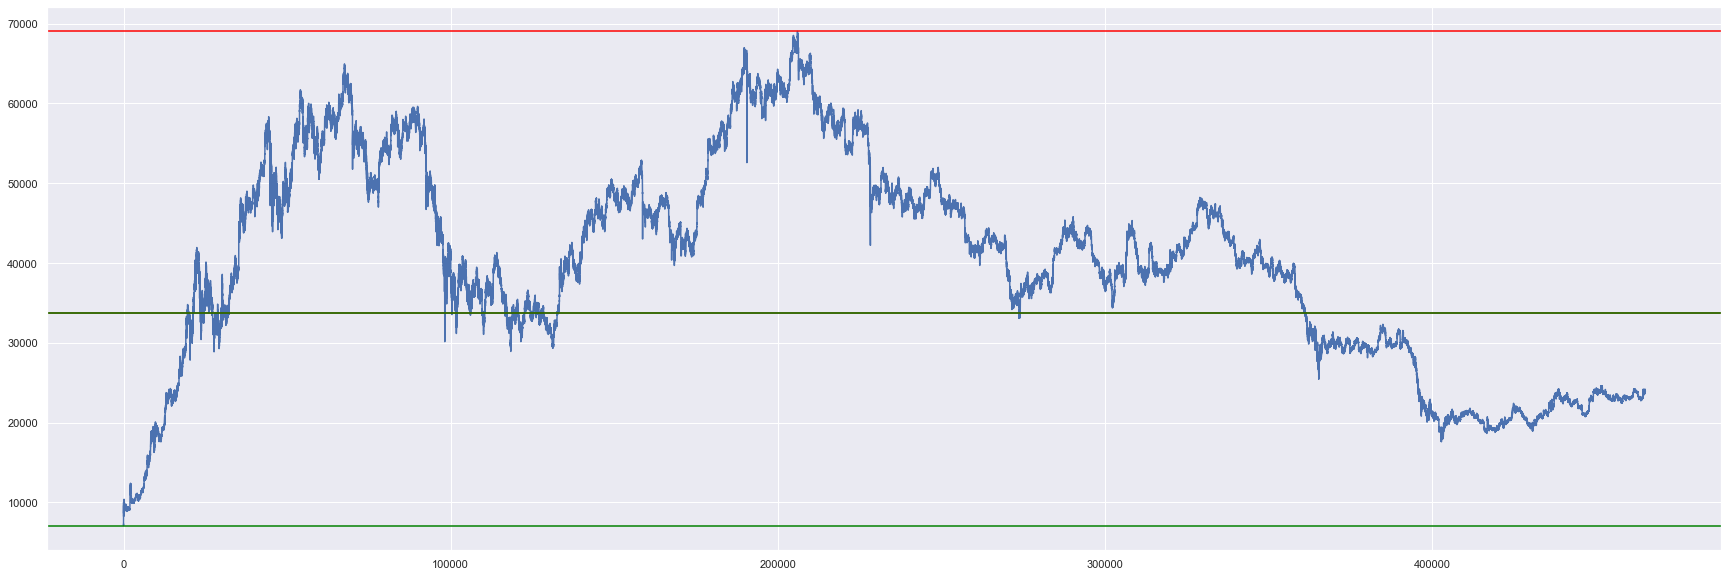

In [13]:
fig = sns.lineplot(data=data.to_numpy())
for value in SupportResistance(data.to_numpy()).support_resistance:
    fig.axhline(y=value[0], color="green")
    fig.axhline(y=value[1], color="red")

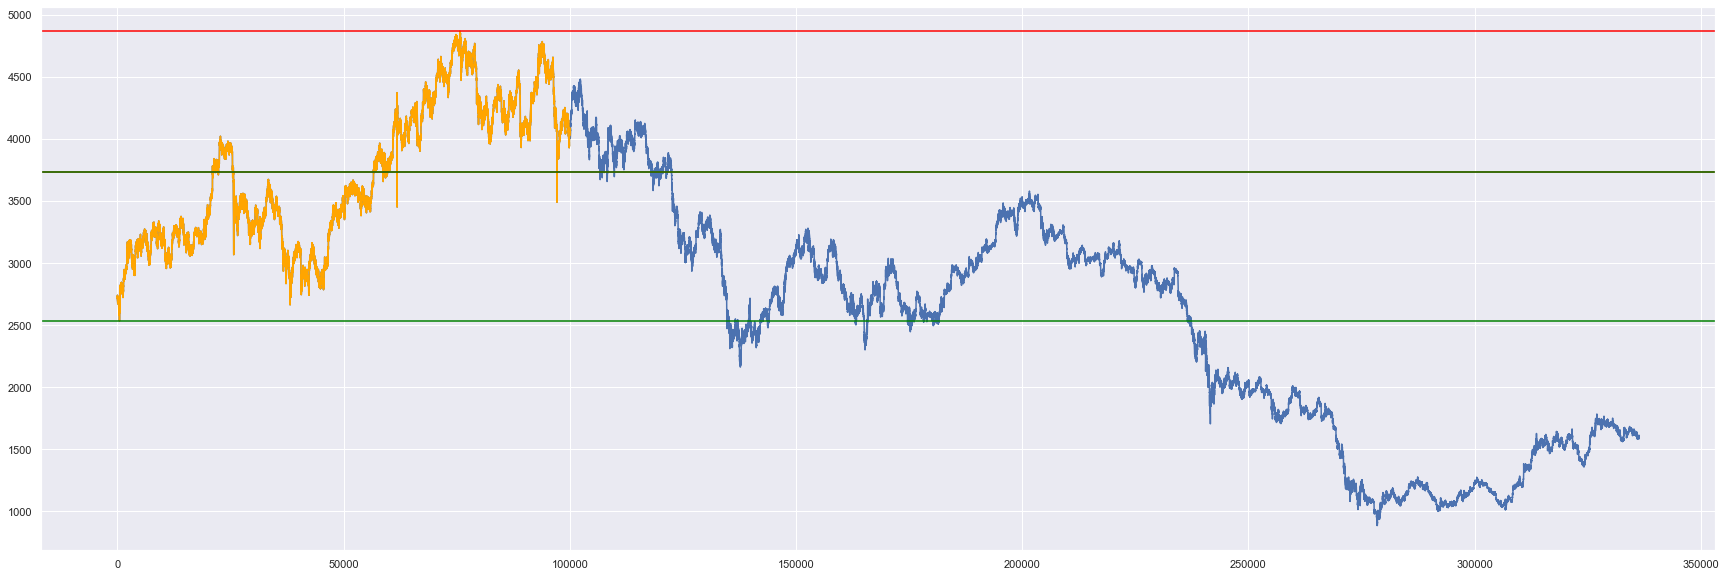

In [6]:
data_limit_size = 100000
slicer = [0,data_limit_size, data_limit_size + 50000]
limit_data = data[slicer[0]:slicer[1]].to_numpy()
sub_data = data[slicer[1]:].to_numpy()
fig = sns.lineplot(data=np.append(limit_data, sub_data))
sns.lineplot(data=limit_data, color="orange")
for value in SupportResistance(limit_data).support_resistance:
    fig.axhline(y=value[0], color="green")
    fig.axhline(y=value[1], color="red")

<AxesSubplot:xlabel='timestamp', ylabel='close'>

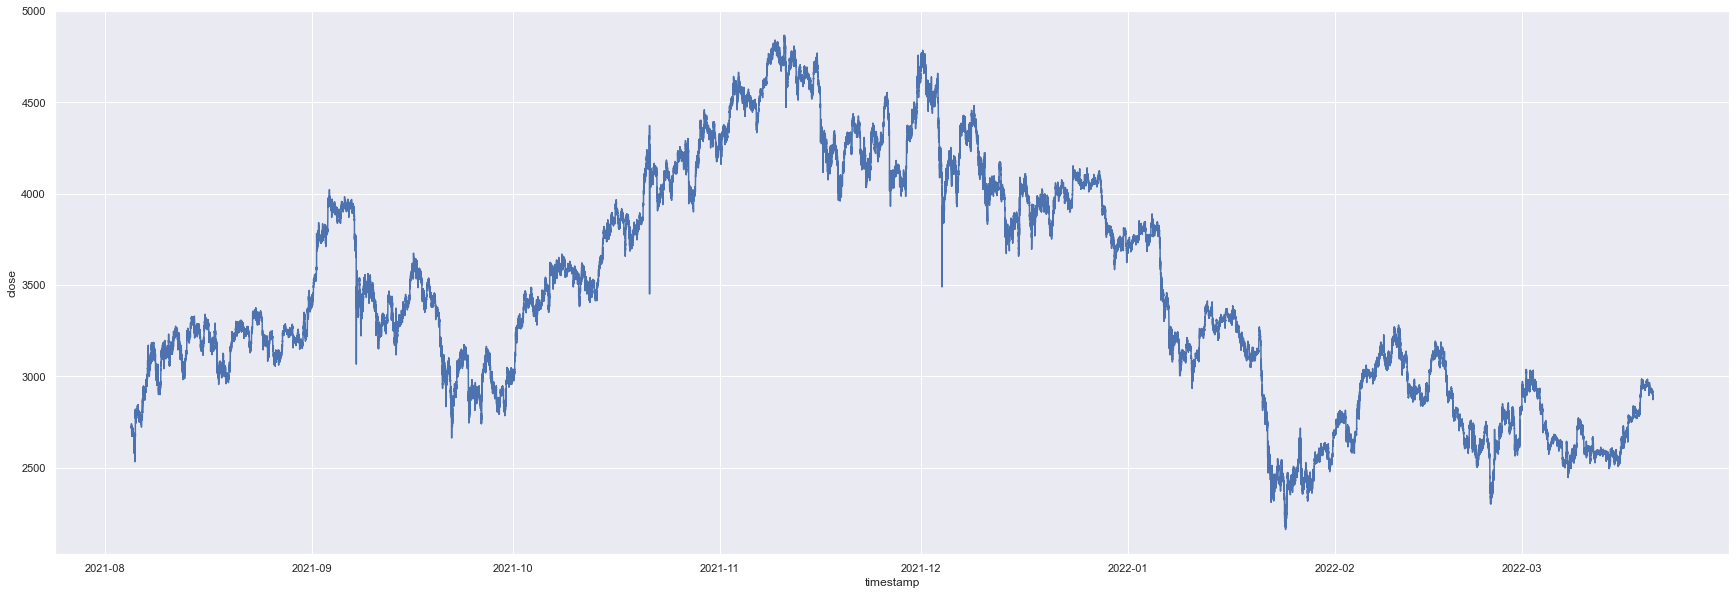

In [3]:
limit_data = data[:-150000]
sns.lineplot(data=limit_data)

In [4]:
from utils import SupportResistance

In [5]:
sp = SupportResistance(limit_data.to_numpy())

In [6]:
limit = sp.get_limits(limit_data[-1])
limit

array([2162. , 4866.1])

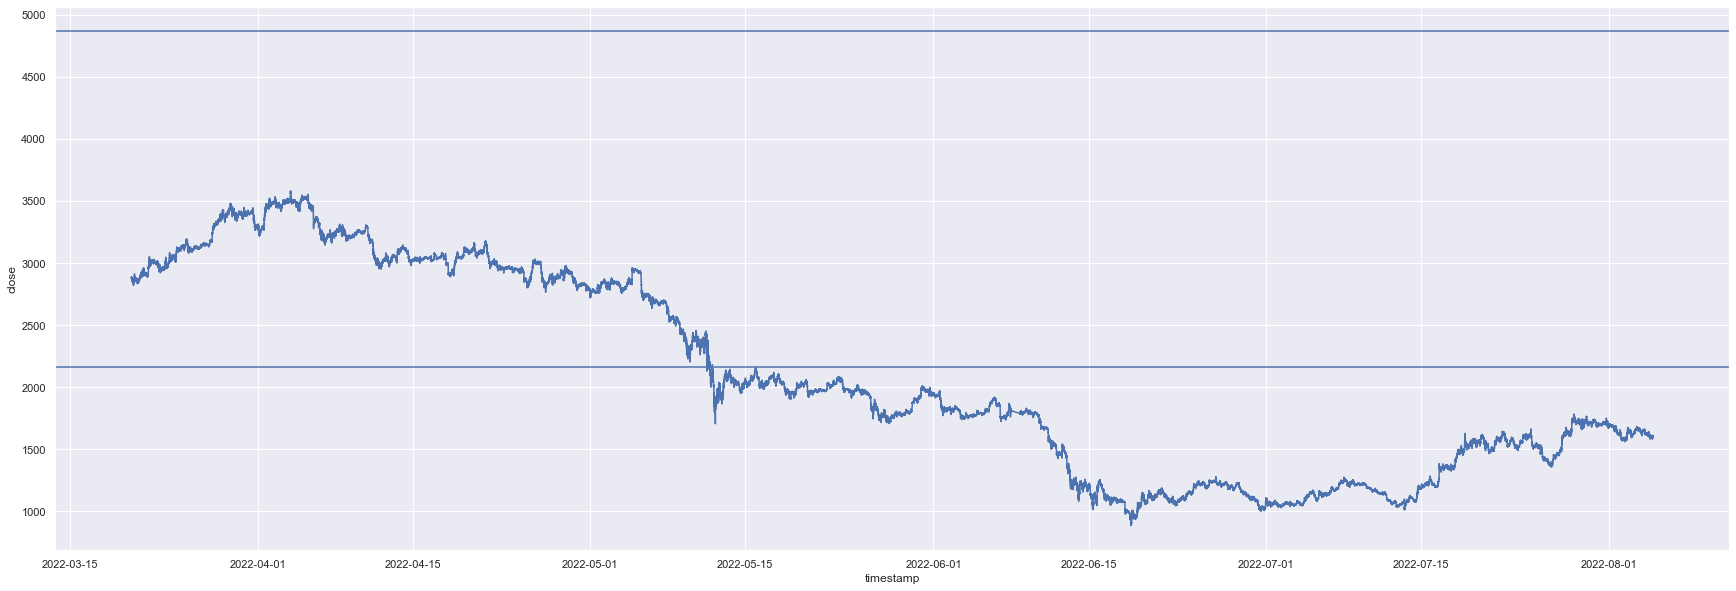

In [7]:
sub_data = data[-150000:]
fig = sns.lineplot(data=sub_data)
fig.axhline(y=limit[0])
fig.axhline(y=limit[1])

# 30.2s

In [14]:
gridbot = GridBot(
    init_wallet = 1000,
    limits = limit,
    nb_grid = 100,
    fees = 0,
    profit_mult = 1,
    bet_mult = 1,
    first_timestamp = sub_data.index[0],
    first_price = sub_data.iloc[0],
)

result_manager = gridbot.get_results()[:0]

for i in range(len(sub_data[1:-1])):
    print(f"[{i+1}/{len(sub_data[1:-1])}]", end="\r")
    trade = gridbot.feed(sub_data.index[i], sub_data.iloc[i])
    if not trade:
        result_manager = pd.concat([result_manager, gridbot.get_results()])
        
        trade = gridbot.sell_all(sub_data.index[i], sub_data.iloc[i])
        limit_data = data.loc[data.index <= trade['timestamp']]
        
        
        gridbot = GridBot(
            init_wallet = trade['wallet'],
            limits = SupportResistance(limit_data.to_numpy()).get_limits(limit_data[-1]),
            nb_grid = 100,
            fees = 0,
            profit_mult = 1,
            bet_mult = 1,
            first_timestamp = trade['timestamp'],
            first_price = trade['price'],
        )
trade = gridbot.sell_all(sub_data.index[i], sub_data.iloc[i])
result_manager = pd.concat([result_manager, gridbot.get_results()]).reset_index(drop=True)

In [15]:
result_manager

,timestamp,price,qty,wallet,take_profit,grid_index
0,2022-03-20 13:34:00+00:00,2879.7,0.0,1000.000000,NaN,27
1,2022-03-20 13:34:00+00:00,2879.7,0.0,1000.000000,NaN,27
2,2022-03-20 13:35:00+00:00,2878.6,0.0,1000.000000,NaN,27
3,2022-03-20 13:36:00+00:00,2874.9,0.0,1000.000000,NaN,27
4,2022-03-20 13:37:00+00:00,2875.2,0.0,1000.000000,NaN,27
...,...,...,...,...,...,...
149995,2022-08-04 23:55:00+00:00,1608.9,0.0,876.802200,NaN,40
149996,2022-08-04 23:56:00+00:00,1608.6,0.0,876.802200,NaN,40
149997,2022-08-04 23:57:00+00:00,1609.2,0.0,876.802200,NaN,40
149998,2022-08-04 23:58:00+00:00,1607.6,0.0,876.802200,NaN,40


In [16]:
plt.figure(figsize=(200,100))
plt.subplot(2,1,1)
fig = sns.lineplot(data=result_manager, y="price", x=result_manager.index)
sns.scatterplot(data=result_manager['price'].where(result_manager.qty > 0), color="red")
for val in gridbot.grid:
    fig.axhline(y=val)
plt.subplot(2,1,2)
fig = sns.lineplot(data=result_manager.wallet)
fig.axhline(y=0)
fig.axhline(y=1000)
plt.savefig('output.png')
plt.close()